In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [39]:
vehiculo = 'DA03'

In [40]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

82

In [41]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [42]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [43]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

37

In [44]:
contenido_filtrado

['2025-12-01 09-55-40.tlog',
 '2025-12-01 15-30-10.tlog',
 '2025-12-01 15-39-27.tlog',
 '2025-12-01 16-41-47.tlog',
 '2025-12-01 21-27-25.tlog',
 '2025-12-02 14-26-35.tlog',
 '2025-12-02 22-34-02.tlog',
 '2025-12-03 01-11-42.tlog',
 '2025-12-03 01-23-39.tlog',
 '2025-12-03 02-07-29.tlog',
 '2025-12-03 02-33-49.tlog',
 '2025-12-03 02-52-16.tlog',
 '2025-12-03 03-27-57.tlog',
 '2025-12-03 04-54-51.tlog',
 '2025-12-03 05-36-15.tlog',
 '2025-12-03 06-12-28.tlog',
 '2025-12-03 06-18-37.tlog',
 '2025-12-03 16-34-57.tlog',
 '2025-12-03 18-06-19.tlog',
 '2025-12-03 20-40-54.tlog',
 '2025-12-03 21-49-01.tlog',
 '2025-12-03 23-29-15.tlog',
 '2025-12-04 00-05-43.tlog',
 '2025-12-04 01-15-05.tlog',
 '2025-12-04 17-45-06.tlog',
 '2025-12-04 18-05-18.tlog',
 '2025-12-04 18-21-03.tlog',
 '2025-12-04 19-33-21.tlog',
 '2025-12-04 20-45-24.tlog',
 '2025-12-04 20-47-33.tlog',
 '2025-12-04 22-26-41.tlog',
 '2025-12-04 23-46-32.tlog',
 '2025-12-05 00-18-38.tlog',
 '2025-12-05 00-56-44.tlog',
 '2025-12-05 0

In [45]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        print(name)
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [46]:
lineas, names = leer_logs(contenido_filtrado)
lineas

2025-12-01 09-55-40.tlog
2025-12-01 15-30-10.tlog
2025-12-01 15-39-27.tlog
2025-12-01 16-41-47.tlog
2025-12-01 21-27-25.tlog
2025-12-02 14-26-35.tlog
2025-12-02 22-34-02.tlog
2025-12-03 01-11-42.tlog
2025-12-03 01-23-39.tlog
2025-12-03 02-07-29.tlog
2025-12-03 02-33-49.tlog
2025-12-03 02-52-16.tlog
2025-12-03 03-27-57.tlog
2025-12-03 04-54-51.tlog
2025-12-03 05-36-15.tlog
2025-12-03 06-12-28.tlog
2025-12-03 06-18-37.tlog
2025-12-03 16-34-57.tlog
2025-12-03 18-06-19.tlog
2025-12-03 20-40-54.tlog
2025-12-03 21-49-01.tlog
2025-12-03 23-29-15.tlog
2025-12-04 00-05-43.tlog
2025-12-04 01-15-05.tlog
2025-12-04 17-45-06.tlog
2025-12-04 18-05-18.tlog
2025-12-04 18-21-03.tlog
2025-12-04 19-33-21.tlog
2025-12-04 20-45-24.tlog
2025-12-04 20-47-33.tlog
2025-12-04 22-26-41.tlog
2025-12-04 23-46-32.tlog
2025-12-05 00-18-38.tlog
2025-12-05 00-56-44.tlog
2025-12-05 02-37-23.tlog
2025-12-05 02-53-59.tlog
2025-12-05 03-32-54.tlog


[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.265 -17.322, -63.265 -17.322, -63.265 -17.322, -63.265 -17....>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.265 -17.322, -63.265 -17.322, -63.265 -17.322, -63.265 -17....>,
 <LINESTRING (-63.264 -17.316, -63.264 -17.316, -63.264 -17.316, -63.264 -17....>,
 <LINESTRING (-62.984 -17.188, -62.984 -17.188, -62.984 -17.188, -62.984 -17....>,
 <LINESTRING (-62.992 -17.171, -62.992 -17.171, -62.992 -17.171, -62.992 -17....>,
 <LINESTRING (-63.174 -17.353, -63.174 -17.353, -63.174 -17.353, -63.174 -17....>,
 <LINESTRING (-62.988 -17.194, -62.988 -17.194, -62.988 -17.194, -62.988 -17....>,
 <LINESTRING (-63.204 -17.321, -63.204 -17.321, -63.204 -17.321, -63.204 -17....>,
 <LINESTRING (-63.204 -17.321, -63.204 -17.321, -63.204 -17.321, -63.204 -17....>,
 <LINESTRING (-62.809 -17.237, -62.809 -17.237, -62.809 -17.237, -62.809 -17....>,
 <LI

In [47]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-12-01 09-55-40.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2025-12-01 15-30-10.tlog,"LINESTRING (-63.26478 -17.32193, -63.26478 -17..."
2,2025-12-01 15-39-27.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


In [48]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [49]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [50]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [51]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-12-01 15-30-10.tlog,"LINESTRING (-63.26478 -17.32193, -63.26478 -17...",374,DA03
1,2025-12-01 15-39-27.tlog,"LINESTRING (-63.26360 -17.31635, -63.26360 -17...",93,DA03
2,2025-12-01 16-41-47.tlog,"LINESTRING (-63.26474 -17.32192, -63.26474 -17...",77,DA03


<Axes: >

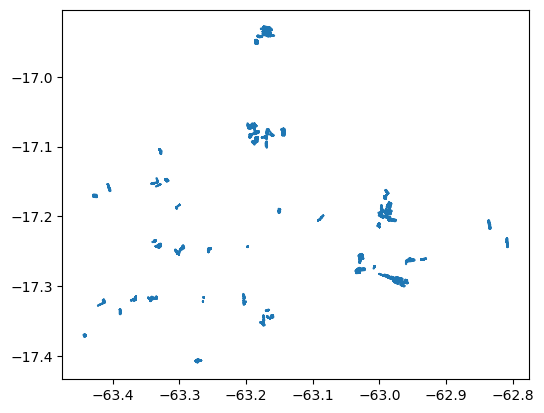

In [52]:
gdf_lines.plot()

In [53]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

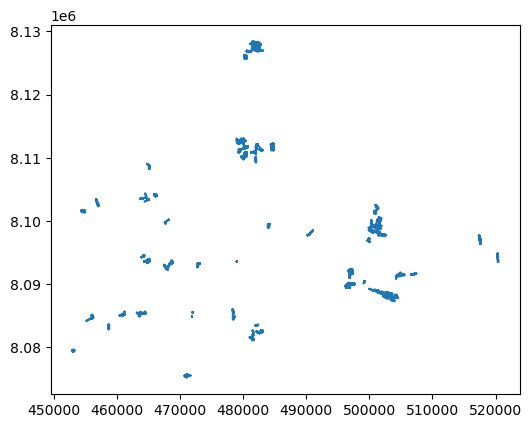

In [54]:
gdf_lines_utm.plot()

In [55]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [56]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-12-01 15-30-10.tlog,"LINESTRING (471864.576 8084811.817, 471864.565...",374,DA03,0
1,2025-12-01 15-39-27.tlog,"LINESTRING (471989.034 8085428.781, 471988.991...",93,DA03,0
2,2025-12-01 16-41-47.tlog,"LINESTRING (471868.422 8084812.353, 471868.432...",77,DA03,0
3,2025-12-01 21-27-25.tlog,"LINESTRING (471987.907 8085444.655, 471987.982...",336,DA03,0
4,2025-12-01 21-27-25.tlog,"LINESTRING (471973.437 8085442.278, 471973.737...",250,DA03,0
...,...,...,...,...,...
71,2025-12-05 02-37-23.tlog,"LINESTRING (480120.985 8112744.698, 480120.985...",1618,DA03,0
72,2025-12-05 02-53-59.tlog,"LINESTRING (481246.464 8110828.833, 481246.453...",1697,DA03,0
73,2025-12-05 02-53-59.tlog,"LINESTRING (481976.862 8109997.326, 481976.787...",2010,DA03,0
74,2025-12-05 02-53-59.tlog,"LINESTRING (482235.357 8112099.207, 482235.325...",3254,DA03,0


In [57]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)